<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/NMDAExploration_reduced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Stylized-Cell-model/

def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    #print(np.argwhere(threshold_crossings))
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    #print(upward_crossings)
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        print(legit_up_crossings)
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[p, legit_uc_iso[ind1]] #current @ up_crossing[ind1] # and here
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[p, legit_uc_iso[ind1]:legit_dc_iso[ind1]] < 1.3*e1, prepend=False))  ## p is swaped in comparision to the full model exploration
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[p, legit_uc_iso[ind1]:legit_dc_iso[ind1]] < 1.15*e1, prepend=False))  ## and here
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[p, legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2])/10)     #as well as here
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[p, legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2])/10)     # and here
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stylized-Cell-model


In [2]:

########

In [3]:
segdata = h5py.File('Segments.hdf5','r')
exc_syns_per_seg = segdata['neSyn']
inh_syns_per_seg = segdata['niSyn']




segs = pd.DataFrame(columns=['segmentID','sec','Type','Elec_distance','X','Y'])


print(segdata['Segs'])

segs.segmentID = segdata['Segs'][:]
segs.set_index('segmentID')
segs.sec = segdata['sec'][:]
segs.Type = [0] * len(segs.index)
segs.Elec_distance = segdata['elec_dist'][:]
segs.X = segdata['X'][:]
segs.Y = segdata['Y'][:]




#<=10, 17, >=26 

#11, 12, 13, 14, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25

for i in segs.index:
  if segs.sec[i] >= 11 and segs.sec[i] != 17 and segs.sec[i] <= 25:
    segs.Type[i] = 'apic'
  elif segs.sec[i] <= 10 or segs.sec[i] == 17 or segs.sec[i] >= 26:
    segs.Type[i] = 'basal'
  else:
    print('fail')


print(segs.index)


<HDF5 dataset "Segs": shape (167,), type "<i8">
RangeIndex(start=0, stop=167, step=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
#exc_syns_per_seg.head()

In [5]:
v = h5py.File('v_report.hdf5','r')
hva = h5py.File('i_CaHva_report.hdf5','r')
lva = h5py.File('i_CaLva_report.hdf5','r')
ih = h5py.File('ihcn_report.hdf5','r')

nmda = h5py.File('i_nmda_report.hdf5','r')

na = h5py.File('gNaTa_report.hdf5','r')
spks = h5py.File('Spikes.hdf5','r')


In [6]:
spktimes = np.array(spks['spikes'])
print(spktimes)
spkinds = np.sort((spktimes*10).astype(int))
print(spkinds)
print(max(na['gNaTa'][5,:]))



[ 82.4  90.9  99.3 231.5 290.1 355.3 436.7 528.8 646.2 748.2 847.4 943.1]
[ 824  909  993 2315 2901 3553 4367 5288 6462 7481 8473 9430]
0.0013362988140198642


In [7]:
apical = []
basal = []
for i in segs.index:
  if segs.Type[i] == 'apic':
    apical.append(i)
  else:
    basal.append(i)




In [8]:
#print(na['gNaTa'][p,:]*1000)

In [9]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in (apical + basal):
    #print(max(na['gNaTa'][p,:]))
    threshold_crossings = np.diff((na['gNaTa'][p,:]*1000) > 0.003, prepend=False)
    #print(len(threshold_crossings[threshold_crossings == True]))
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    #print(upward_crossings)
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
    if len(na_spks)>0:
        #print('if',p)
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':na_spks}))
    else:
        #print('else',p)
        na_df = na_df.append(pd.DataFrame({'segmentID':p,
                                               'na_lower_bound':np.array([np.nan])}))

In [10]:
na_df.to_csv('na_df.csv')
na_df = pd.read_csv('na_df.csv')
print(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)])



     Unnamed: 0  segmentID  na_lower_bound
0             0         24           807.0
1             1         24          2249.0
2             2         24          2295.0
3             3         24          2841.0
4             4         24          3373.0
..          ...        ...             ...
875           7        159          5354.0
876           8        159          6529.0
877           9        159          7554.0
878          10        159          8555.0
879          11        159          9508.0

[880 rows x 3 columns]


In [11]:
# print(trace>half_peak)
# print(len(np.arange(0,20)))

# np.arange(0,20)[trace>half_peak]



In [12]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['gNaTa'][seg,spkt-10:spkt+10]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [13]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [14]:
print(na_df.segmentID)

0       24
1       24
2       24
3       24
4       24
      ... 
882    162
883    163
884    164
885    165
886    166
Name: segmentID, Length: 887, dtype: int64


In [15]:
segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

In [16]:
na_df.set_index('segmentID')


,Unnamed: 0,na_lower_bound,duration_low,duration_high,peak_value,duration
segmentID,,,,,,
24,0,807.0,797.0,816.0,0.000004,2.0
24,1,2249.0,2239.0,2258.0,0.000003,2.0
24,2,2295.0,2285.0,2304.0,0.000004,2.0
24,3,2841.0,2831.0,2850.0,0.000003,2.0
24,4,3373.0,3363.0,3382.0,0.000004,2.0
...,...,...,...,...,...,...
162,0,NaN,NaN,NaN,NaN,NaN
163,0,NaN,NaN,NaN,NaN,NaN
164,0,NaN,NaN,NaN,NaN,NaN


In [17]:
segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&(segs_na_df.Type=='basal')]

,segmentID,sec,Type,Elec_distance,X,Y,Unnamed: 0,na_lower_bound,duration_low,duration_high,peak_value,duration
0,0,1.0,basal,0.999988,0.0,0.0,0,696.0,686.0,705.0,0.000004,2.0
1,0,1.0,basal,0.999988,0.0,0.0,1,1881.0,1871.0,1890.0,0.000003,2.0
2,0,1.0,basal,0.999988,0.0,0.0,2,2618.0,2608.0,2627.0,0.000003,2.0
3,0,1.0,basal,0.999988,0.0,0.0,3,3271.0,3261.0,3280.0,0.000003,2.0
4,0,1.0,basal,0.999988,0.0,0.0,4,3896.0,3886.0,3905.0,0.000003,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
875,159,33.0,basal,0.999988,0.0,0.0,7,5354.0,5347.0,5363.0,0.000004,1.7
876,159,33.0,basal,0.999988,0.0,0.0,8,6529.0,6522.0,6538.0,0.000004,1.7
877,159,33.0,basal,0.999988,0.0,0.0,9,7554.0,7544.0,7563.0,0.000004,2.0
878,159,33.0,basal,0.999988,0.0,0.0,10,8555.0,8545.0,8564.0,0.000003,2.0


In [18]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='basal')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='basal')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [19]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)

In [20]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [21]:
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

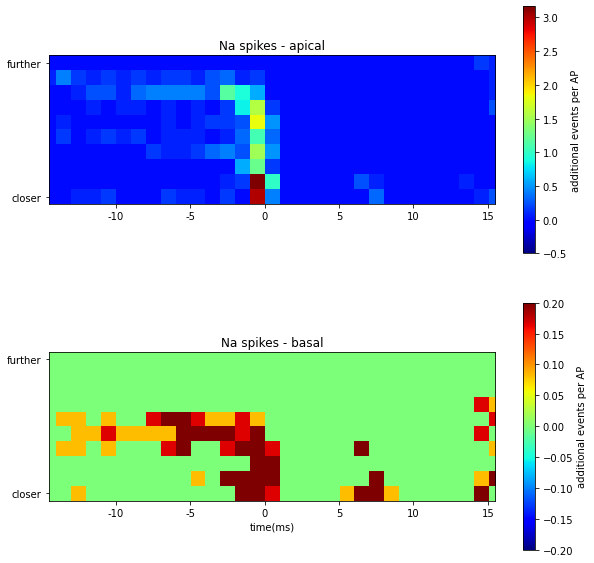

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)

plt.show()

----------

In [23]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])

segIDs = segs.index #segs[(segs.Type=='apic')]['segmentID']
for p in segIDs:
    #print(p)
    trace = hva['i_CaHva'][p,:]+\
            lva['i_CaLva'][p,:]+\
            ih['ihcn'][p,:]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['v'][p,:],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['v'][p,:],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['i_CaHva'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

[ 806 3465 3960 4840 5787 6888 7883 8724]
[ 806 3465 3960 4840 5787 6888 7883 8724]
[ 777 2209 2758]
[ 777 2209 2758]
[756]
[756]
[ 812 3467 3957 4858 5782 6858 7915 8905]
[ 812 3467 3957 4858 5782 6858 7915 8905]
[ 787 2071]
[ 787 2071]
[762]
[762]
[ 811 3486 3980 4858 5779 6821 7839 8913]
[ 811 3486 3980 4858 5779 6821 7839 8913]
[ 780 2722 3259]
[ 780 2722 3259]
[758]
[758]
[ 819 3470 3942 4669 5744 6801 7823 8925]
[ 819 3470 3942 4669 5744 6801 7823 8925]
[ 803 2706]
[ 803 2706]
[787]
[787]
[732]
[732]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[737]
[737]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[ 746 1528]
[ 746 1528]
[735]
[735]
[728]
[728]
[]
[]
[]
[]
[]
[]
[]
[]
[773]
[773]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


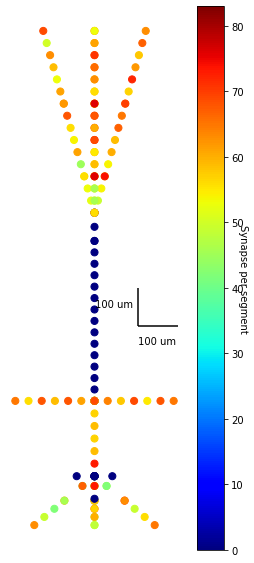

In [24]:
plt.figure(figsize=(4,10))
ax = plt.scatter(segdata['X'], segdata['Y'], c=segdata['neSyn'][0:167],s=50,cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Synapse per segment', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

In [25]:
ca_df.to_csv('ca_df.csv')
ca_df = pd.read_csv('ca_df.csv')

# durations

In [26]:
segs[(segdata['X'][:]>600)&(segdata['Y'][:]<800)]

,segmentID,sec,Type,Elec_distance,X,Y


In [27]:
# np.random.choice(segs[(segs['Coord Y']<-50)&
#      (segs['Coord Y']>-100)&
#      (segs['Coord X']>-50)&
#      (segs['Coord X']<50)&
#      (segs['Type']=='dend')]['segmentID'])

## Plotting morphology as heat maps

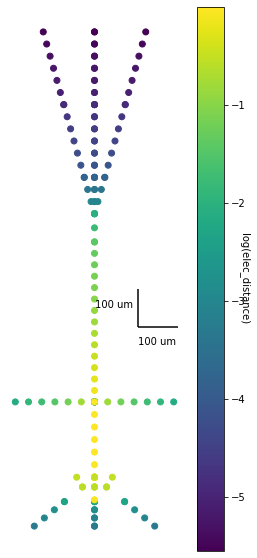

In [28]:
plt.figure(figsize=(4,10))
ax = plt.scatter(segdata['X'], segdata['Y'], c=np.log(segdata['elec_dist']))
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

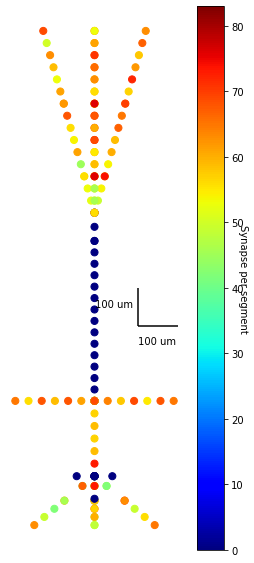

In [29]:
plt.figure(figsize=(4,10))
ax = plt.scatter(segdata['X'], segdata['Y'], c=segdata['neSyn'][0:167],s=50,cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Synapse per segment', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

## Plotting morphology and voltage traces

In [30]:
print(segs['X'][:])
print(segdata['X'][:])

0      0.000000e+00
1      3.040978e+01
2      0.000000e+00
3      1.862062e-15
4      0.000000e+00
           ...     
162    2.755455e-15
163    0.000000e+00
164   -4.500000e+01
165    0.000000e+00
166   -8.266366e-15
Name: X, Length: 167, dtype: float64
[ 0.00000000e+00  3.04097843e+01  0.00000000e+00  1.86206217e-15
  0.00000000e+00 -3.04097843e+01  0.00000000e+00 -5.58618652e-15
  3.04097843e+01  7.60244598e+01  1.86206217e-15  4.65515544e-15
 -3.04097843e+01 -7.60244598e+01 -5.58618652e-15 -1.39654667e-14
  7.60244598e+01  1.01365946e+02  1.26707433e+02  1.52048920e+02
  4.65515544e-15  6.20687391e-15  7.75859239e-15  9.31031087e-15
 -7.60244598e+01 -1.01365946e+02 -1.26707433e+02 -1.52048920e+02
 -1.39654667e-14 -1.86206223e-14 -2.32757779e-14 -2.79309335e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.33333333e+01  6.66666667e+01  1.00000000e+02  1.33333333e+02
  1.66666667e+02  2.00000000

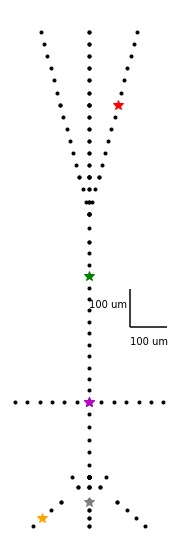

In [31]:
tics = len(v['v'][0])/10

plt.figure(figsize=(3,10))
ax = plt.plot(segdata['X'][:], segdata['Y'][:],'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segdata['X'][129], 
         segdata['Y'][129],
         'r*', markersize=10)
plt.plot(segdata['X'][46], 
         segdata['Y'][46],
         'b*', markersize=10)
plt.plot(segdata['X'][60], 
         segdata['Y'][60],
         'm*', markersize=10)
plt.plot(segdata['X'][78], 
         segdata['Y'][78],
         'g*', markersize=10)
plt.plot(segdata['X'][26], 
         segdata['Y'][26],
         '*',color='orange',markersize=10)
plt.plot(segdata['X'][20], 
         segdata['Y'][20],
         '*',color='grey', markersize=10)
plt.savefig('fig1A.svg')

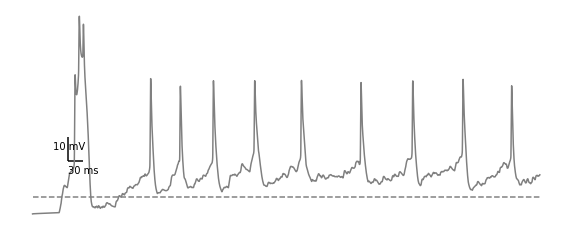

In [32]:

plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][20,:],color='grey')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

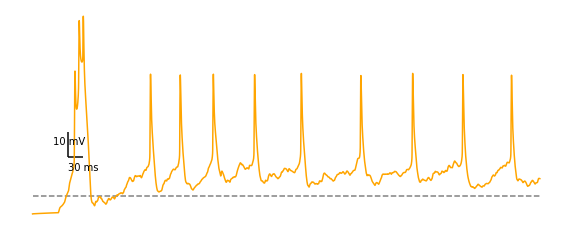

In [33]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][26,:],color='orange')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F.svg')

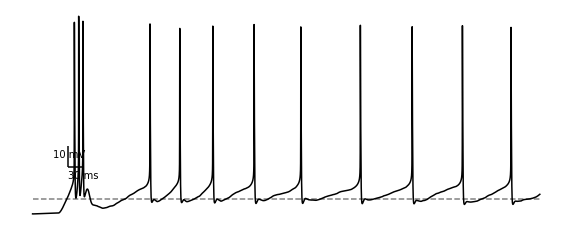

In [34]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][0,:],color='k')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

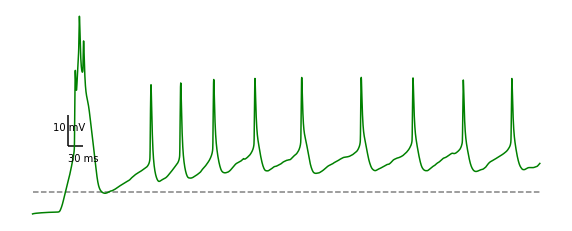

In [35]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][78,:],color='g')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

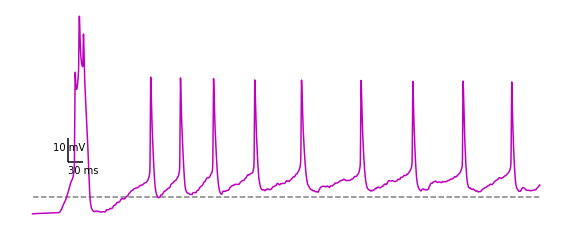

In [36]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][60,:],color='m')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2D.svg')

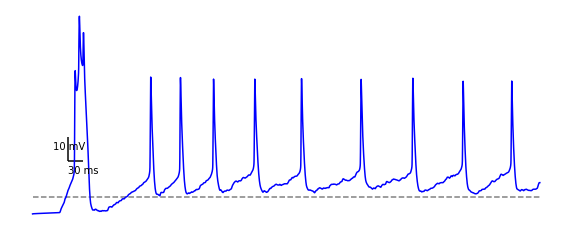

In [37]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][46,:],color='b')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

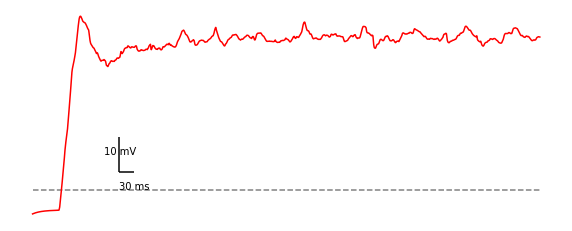

In [38]:
plt.figure(figsize=(10,4))
s1 = 323548+1500#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][129,:],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.hlines(-65,0,1000, color = 'grey', linestyle = 'dashed')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

([], <a list of 0 Text major ticklabel objects>)

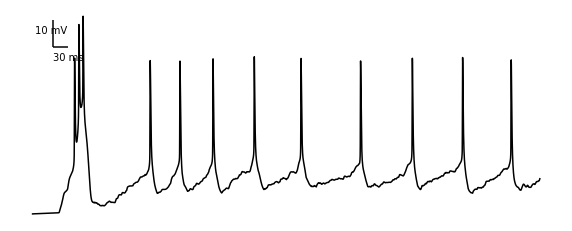

In [39]:
plt.figure(figsize=(10,4))
s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,tics,.1),v['v'][10,:],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [40]:
x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
i = np.random.choice(x.index)

(0.0, 200.0)

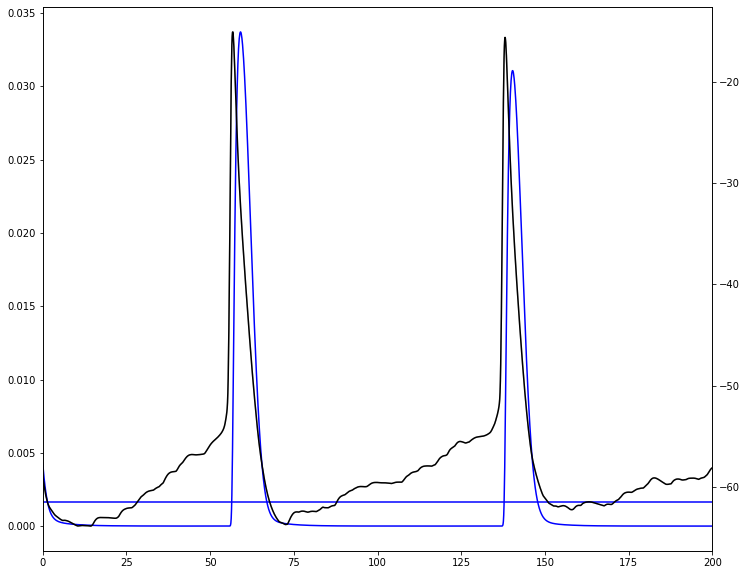

In [41]:
seg = 60
lower_bound = 4000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,600,.1),-(hva['i_CaHva'][seg,lower_bound-1000:lower_bound+5000]+\
         lva['i_CaLva'][seg,lower_bound-1000:lower_bound+5000]+\
         ih['ihcn'][seg,lower_bound-1000:lower_bound+5000]),color='b')
plt.hlines(np.mean(-(hva['i_CaHva'][seg,lower_bound-1000:lower_bound+5000]+\
         lva['i_CaLva'][seg,lower_bound-1000:lower_bound+5000]+\
         ih['ihcn'][seg,lower_bound-1000:lower_bound+5000])),0,300.1,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,600,.1),v['v'][seg,lower_bound-1000:lower_bound+5000],color='k')
plt.plot(np.arange(0,600,.1),v['v'][seg,lower_bound-1000:lower_bound+5000],color='k',alpha=0.2)
plt.xlim(0,200)


In [42]:
ca_df.reset_index(inplace=True)

In [43]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>2000) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        print(spkt)
        print(max(hva['i_CaHva'][seg,spkt-500:spkt+500]))
        print(max(lva['i_CaLva'][seg,spkt-500:spkt+500]))
        print(max(ih['ihcn'][seg,spkt-500:spkt+500]))
        
        trace = -(hva['i_CaHva'][seg,spkt-500:spkt+500] + \
                lva['i_CaLva'][seg,spkt-500:spkt+500] + \
                ih['ihcn'][seg,spkt-500:spkt+500])
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,1000)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

9329
-1.9847865540813465e-05
-1.1337104244327484e-07
1.955554382304227e-06
8424
-2.8374906717362877e-06
-1.3728922138335948e-07
2.717276401079663e-06
7352
-3.5037954415448375e-06
-1.3865488276253446e-07
2.6861124620987336e-06
5816
-9.41640840342512e-06
-1.0243571085370203e-07
2.1567116880016797e-06
7365
-3.6606924104394747e-06
-1.3922122491688838e-07
2.6627437110773068e-06
8957
-1.3615791502931838e-05
-1.0933680824661845e-07
2.0433369623239105e-06
6292
-2.511750982193403e-06
-1.3752567809838746e-07
2.6907307622261e-06
4343
-2.3032157233006397e-06
-1.3102260594030156e-07
3.0786763619419074e-06
8969
-1.1857497798524996e-05
-1.0207429326987658e-07
1.9899752801221664e-06
7349
-3.4762899367805624e-06
-1.382830957827957e-07
2.671053717138252e-06
7109
-1.8260330137732623e-05
-9.924901178043616e-08
1.953633102436156e-06
4899
-1.2800751760783493e-05
-1.0797306273693535e-07
2.2998877735309027e-06
8969
-1.1857497798524996e-05
-1.0207429326987658e-07
1.9899752801221664e-06
6312
-2.757299544930248e

In [44]:
ca_df[~pd.isnull(ca_df.duration_high)]

,index,Unnamed: 0,segmentID,ca_lower_bound,ca_upper_bound,mag,duration_low,duration_high,peak_value
87,87,1,86,4337.0,4522.0,-0.002857,4892.0,5012.0,0.000262
88,88,2,86,5256.0,5462.0,-0.003646,5814.0,5951.0,0.000292
89,89,3,86,6312.0,6641.0,-0.003717,6985.0,7119.0,0.000269
91,91,5,86,8435.0,8629.0,-0.002535,8996.0,9116.0,0.000224
92,92,6,86,9308.0,9586.0,-0.002464,9953.0,10072.0,0.000204
94,94,1,87,3507.0,3741.0,-0.003148,4077.0,4198.0,0.000254
96,96,3,87,4936.0,5497.0,-0.006422,4926.0,5925.0,0.000332
97,97,4,87,5824.0,6699.0,-0.007865,5814.0,5967.0,0.000332
99,99,6,87,8044.0,8696.0,-0.005816,8034.0,9033.0,0.000280
100,100,7,87,9329.0,9670.0,-0.004181,9949.0,10093.0,0.000236


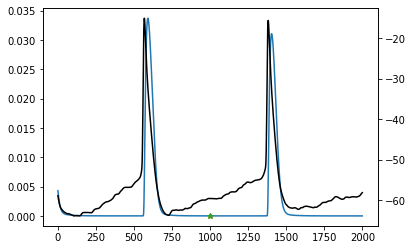

In [45]:
seg = 60
lower_bound = 4000
#upper_bound = 
plt.plot(-(hva['i_CaHva'][seg,lower_bound-1000:lower_bound+1000]+\
         lva['i_CaLva'][seg,lower_bound-1000:lower_bound+1000]+\
         ih['ihcn'][seg,lower_bound-1000:lower_bound+1000]))
plt.plot(1000,-(hva['i_CaHva'][seg,lower_bound]+\
         lva['i_CaLva'][seg,lower_bound]+\
         ih['ihcn'][seg,lower_bound]),'*')

plt.plot(1000+4000-lower_bound,-(hva['i_CaHva'][seg,4000]+\
         lva['i_CaLva'][seg,4000]+\
         ih['ihcn'][seg,4000]),'*')

plt.twinx()
plt.plot(v['v'][seg,lower_bound-1000:lower_bound+1000],color='k')

----------

In [46]:
print(ca_df.set_index('segmentID'))


           index  Unnamed: 0  ca_lower_bound  ca_upper_bound  mag  \
segmentID                                                           
0              0           0             NaN             NaN  NaN   
1              1           0             NaN             NaN  NaN   
2              2           0             NaN             NaN  NaN   
3              3           0             NaN             NaN  NaN   
4              4           0             NaN             NaN  NaN   
...          ...         ...             ...             ...  ...   
162          221           0             NaN             NaN  NaN   
163          222           0             NaN             NaN  NaN   
164          223           0             NaN             NaN  NaN   
165          224           0             NaN             NaN  NaN   
166          225           0             NaN             NaN  NaN   

           duration_low  duration_high  peak_value  
segmentID                                        

In [47]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID'))
#reset_index() 
#segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

print(segs_ca_df[~pd.isnull(ca_df.duration_high)])

#segs_ca_df[~pd.isnull(ca_df.duration_high)]

            sec   Type  Elec_distance             X            Y  index  \
segmentID                                                                 
87         20.0   apic       0.033333  1.725441e+01   764.395101     93   
87         20.0   apic       0.033333  1.725441e+01   764.395101     94   
87         20.0   apic       0.033333  1.725441e+01   764.395101     95   
87         20.0   apic       0.033333  1.725441e+01   764.395101     96   
87         20.0   apic       0.033333  1.725441e+01   764.395101     97   
...         ...    ...            ...           ...          ...    ...   
153        31.0  basal       0.005268 -1.901750e-14  1086.370605    212   
154        31.0  basal       0.004752 -2.060229e-14  1118.568156    213   
155        31.0  basal       0.004289 -2.218708e-14  1150.765706    214   
156        31.0  basal       0.003872 -2.377187e-14  1182.963257    215   
158        32.0  basal       0.919452  0.000000e+00   -60.000000    217   

           Unnamed: 0  c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [48]:
# segs_ca_df = ca_df.set_index('segmentID')
# print(segs_ca_df)

In [49]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,39,))
    
    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='basal')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='basal')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [50]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [51]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

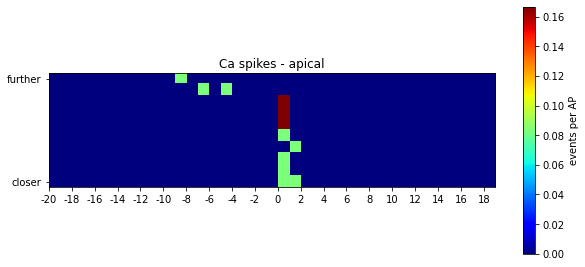

In [52]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])

plt.show()

----------------------

In [53]:
#apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

#basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [ ]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs.index: #[(segs.Type=='dend')|(segs.Type=='apic')]
    legit_uc = voltage_criterion(data=v['v'][p,:],v_thresh=-40, time_thresh=10)[1]
    legit_dc = voltage_criterion(data=v['v'][p,:],v_thresh=-40, time_thresh=10)[-1]

    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
  
    if (len(legit_uc_iso)!=0) & (np.min(nmda['i_nmda'][p,:])!=0):
        
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['i_nmda'])
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

In [55]:
print(max(nmda_df.nmda_lower_bound))

nan


In [56]:
nmda_df.to_csv('nmda_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')

In [96]:
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [58]:
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [ ]:
#print(segs_nmda_df)

In [ ]:
 print(segs_nmda_df[segs_nmda_df.index==1])

 print(min(segs_nmda_df.mag))

In [61]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                   (segs_nmda_df.Type=='basal')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.00001)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='basal')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [62]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)

In [63]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))

In [64]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

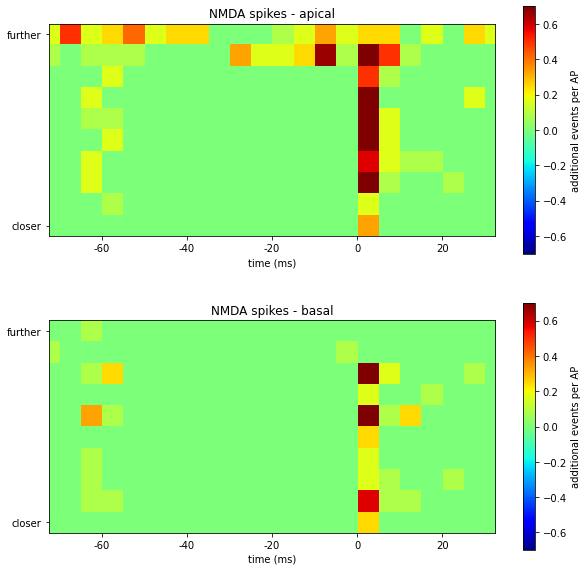

In [65]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.7,vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.7, vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.show()

<BarContainer object of 2 artists>

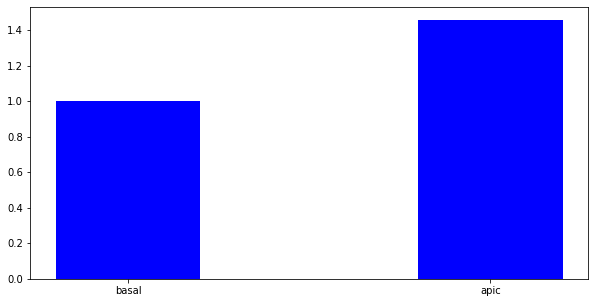

In [108]:
total_basal_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='basal'].value_counts())
num_basal_seg = len(segs_nmda_df['segmentID'][segs_nmda_df.Type=='basal'].value_counts())

total_apic_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='apic'].value_counts())
num_apic_seg = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='apic'].value_counts())

apic_nmda_perSeg_perSec = total_basal_nmda / num_basal_seg
basal_ndma_perSeg_perSec = total_apic_nmda / num_apic_seg



data = {'basal':basal_ndma_perSeg_perSec, 'apic':apic_nmda_perSeg_perSec}
group = list(data.keys())
value = list(data.values())


fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(group, value, color ='blue',
        width = 0.4)





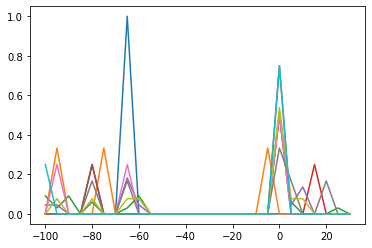

In [66]:
for i in np.arange(0,10):
    plt.plot(np.arange(-100,35,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [67]:
#segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

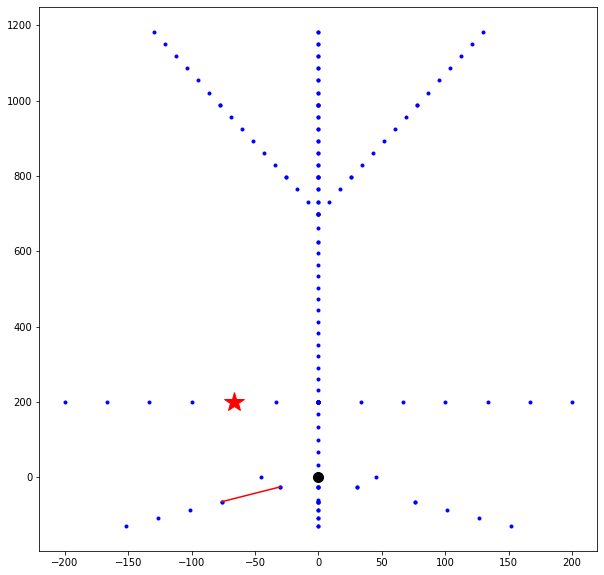

In [68]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['X'], segs['Y'], 'b.')
plt.plot(segs.loc[0,'X'], segs.loc[0,'Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'X'], segs.loc[ind,'Y'], 'r*',markersize=20)

for i in segs[(segs.Type=='basal')&(segs['sec']==7)]['sec'].unique():
    plt.plot(segs[(segs['sec']==i)&(segs['Type']=='basal')]['X'],
             segs[(segs['sec']==i)&(segs['Type']=='basal')]['Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
#plt.ylim(-25,50)
#plt.xlim(-150,150)

In [69]:
# plt.figure(figsize=(10,10))
# plt.plot(f['report']['biophysical']['data'][:,119],color='b')
# plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
# plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

# plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
# plt.plot(f['report']['biophysical']['data'][:,0],'k')
# plt.twinx()
# plt.plot(h['report']['biophysical']['data'][:,119],color='r')
# plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
# plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

# plt.xlim(526519-100,526519+1000)

In [70]:
# nmda2 = np.zeros((79,))

# for i in spktimes:
#     nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
#              (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
#              (segs_nmda_df.mag<-0.1)&
#                 (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

#     x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
#     nmda2 += x2
    
#     #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
#     #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
#     #na3 += x3
    
#     #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
#     #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
#     #na4 += x4
    
#     #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
#     #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
#     #na5 += x5
    

In [71]:
# plt.plot(nmda2)

In [72]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# ind = 1139
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
# plt.ylim(-0.009,0.001)
# plt.xlim(37000,39000)
# plt.ylabel('current (nA)')


In [73]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
# plt.xlim(32000,32400)
# plt.ylim(-0.009,0.001)
# plt.ylabel('current (nA)')


In [74]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [75]:
np.arange(-30,31,5).shape

(13,)

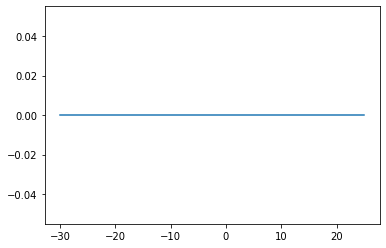

In [76]:
plt.plot(np.arange(-30,30,5),n)

In [77]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

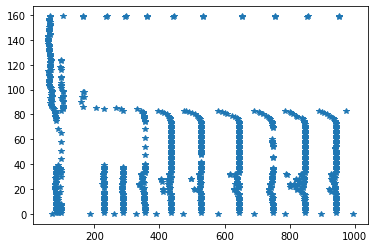

In [78]:
plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
         na_df[~pd.isnull(na_df.na_lower_bound)]['segmentID'],'*')

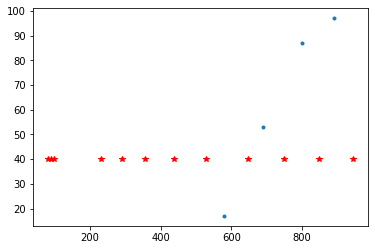

In [79]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [80]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [81]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
# plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
# plt.xlim(6000,7000)

In [82]:
# # ind1 = 3 sent to Drew
# ind1 = 2
# e1 = control_inmda[legit_uc_iso[ind1], p]
# e2 = control_inmda[legit_dc_iso[ind1], p]
# x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
# x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [83]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
# plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.ylabel('current (nA)')
# plt.ylim(-0.010,0)
# plt.legend(loc='upper center')
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


# for i in np.arange(0,len(bounds)):
#     plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#     plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
# ##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
# ##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
# #plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
# ##plt.text(1.5,14,'NMDA\nspike')
# #plt.ylabel('voltage (mV)')
# #plt.legend()

In [84]:
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
# plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

# uc = voltage_criterion(control_v[:,p],-40)[0]


# plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


# center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

# plt.plot([center,center+26],[-80,-80],color='k')
# plt.legend(loc='lower left')

# plt.twinx()
# plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
# #plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
# plt.xlim(center-100,center+100)

# plt.legend(loc='lower right')
# plt.title('{}'.format(legit_uc))

In [85]:
# p = np.random.choice(segs[segs.Type=='apic'].index)
# for i in spktimes:
#     plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
# plt.vlines(10,-65,0,color='k')
# plt.ylim(-65,0)

In [86]:
# p = 829#np.random.choice(segs[segs.Type=='dend'].index)
# plt.title('dend {}'.format(p))
# plt.plot(control_v[7200:7700,p],label='dend')
# plt.plot(control_v[7200:7700,0],label='soma')
# plt.hlines(-40,0,500)
# plt.twinx()
# plt.plot(control_inmda[7200:7700,p],color='r')
# plt.legend()

In [87]:
# control_v[10000,0]

In [88]:
# plt.hist(control_v[10000,:])

In [89]:
# plt.plot(control_v[:,1200])
# plt.plot(NMDAblock_v[:,1200])

In [90]:
# df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [91]:
# df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [92]:
# df[(df.Distance>900) & (df.Distance<1000)]

In [93]:
# plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
# plt.xlim(1740,1760)

In [94]:
# plt.figure(figsize=(10,6))
# plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
# plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
# plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
# plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
# plt.xlabel('distance from soma')
# plt.ylabel('mean potential of segment (mV)')

In [95]:
# #plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

# plt.figure(figsize=(10,6))

# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
# plt.xlim(1.75,2)
# plt.xlabel('time (s)')
# plt.ylabel('membrane potential (mV)')